In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 2: Data Loading
# Save the provided data as 'used-bikes.csv' or load directly
df = pd.read_csv('used bike price data set.csv') # write file location file name and file format


In [4]:
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())


Dataset loaded successfully!
Shape: (7312, 9)
                              bike_name   price       city  kms_driven  \
0    TVS Star City Plus Dual Tone 110cc   35000  Ahmedabad       17654   
1           Royal Enfield Classic 350cc  119900      Delhi       11000   
2                  Triumph Daytona 675R  600000      Delhi         110   
3                  TVS Apache RTR 180cc   65000  Bangalore       16329   
4  Yamaha FZ S V 2.0 150cc-Ltd. Edition   80000  Bangalore       10000   

         owner  age  power          brand  Original Price  
0  First Owner    3    110            TVS           82500  
1  First Owner    4    350  Royal Enfield          230000  
2  First Owner    8    675        Triumph         1100000  
3  First Owner    4    180            TVS          140000  
4  First Owner    3    150         Yamaha          150000  


In [5]:
# 3.1 Remove duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before: 0
Duplicates after: 0


In [6]:
# 3.2 Fix data types and handle missing values
df['price'] = pd.to_numeric(df['price'].astype(str).str.replace(',', ''), errors='coerce')
df['kms_driven'] = pd.to_numeric(df['kms_driven'].astype(str).str.replace(',', ''), errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['power'] = pd.to_numeric(df['power'], errors='coerce')
df['Original Price'] = pd.to_numeric(df['Original Price'].astype(str).str.replace(',', ''), errors='coerce')

In [7]:
print("\nMissing Values before handling:")
print(df.isnull().sum())



Missing Values before handling:
bike_name         0
price             0
city              0
kms_driven        0
owner             0
age               0
power             0
brand             0
Original Price    0
dtype: int64


In [8]:
# Drop rows where target 'price' is missing
df = df.dropna(subset=['price'])
df['owner'] = df['owner'].fillna('First Owner')
df = df.fillna(df.median(numeric_only=True))

In [9]:
# 3.3 Remove outliers using IQR method (except target)
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[col] >= lower) & (data[col] <= upper)]

num_cols = ['kms_driven', 'age', 'power', 'Original Price']
for col in num_cols:
    df = remove_outliers_iqr(df, col)

print("\nShape after outlier removal:", df.shape)



Shape after outlier removal: (6550, 9)


In [10]:
# 3.4 Feature Engineering
df['depreciation'] = df['Original Price'] - df['price']
df['depreciation_rate'] = df['depreciation'] / df['Original Price']
df['kms_per_year'] = df['kms_driven'] / (df['age'] + 1)  # +1 to avoid division by zero

In [13]:
# Categorical encoding
le_owner = LabelEncoder()
df['owner_encoded'] = le_owner.fit_transform(df['owner'])

le_brand = LabelEncoder()
df['brand_encoded'] = le_brand.fit_transform(df['brand'])

le_city = LabelEncoder()
df['city_encoded'] = le_city.fit_transform(df['city'])

print(df.describe())

               price    kms_driven          age        power  Original Price  \
count    6550.000000   6550.000000  6550.000000  6550.000000     6550.000000   
mean    69658.347634  20708.161832     6.220611   211.494809   157869.465649   
std     48985.805843  13450.329871     2.742366   112.326086    70266.320805   
min      5800.000000      1.000000     1.000000   100.000000    50000.000000   
25%     32000.000000  10124.750000     4.000000   125.000000    90000.000000   
50%     55000.000000  18228.000000     6.000000   150.000000   150000.000000   
75%     96250.000000  28472.000000     8.000000   295.000000   215000.000000   
max    860000.000000  60500.000000    14.000000   650.000000   375000.000000   

        depreciation  depreciation_rate  kms_per_year  owner_encoded  \
count    6550.000000        6550.000000   6550.000000    6550.000000   
mean    88211.118015           0.583123   2870.258682       0.176336   
std     39057.550226           0.154612   1691.511472       0.5

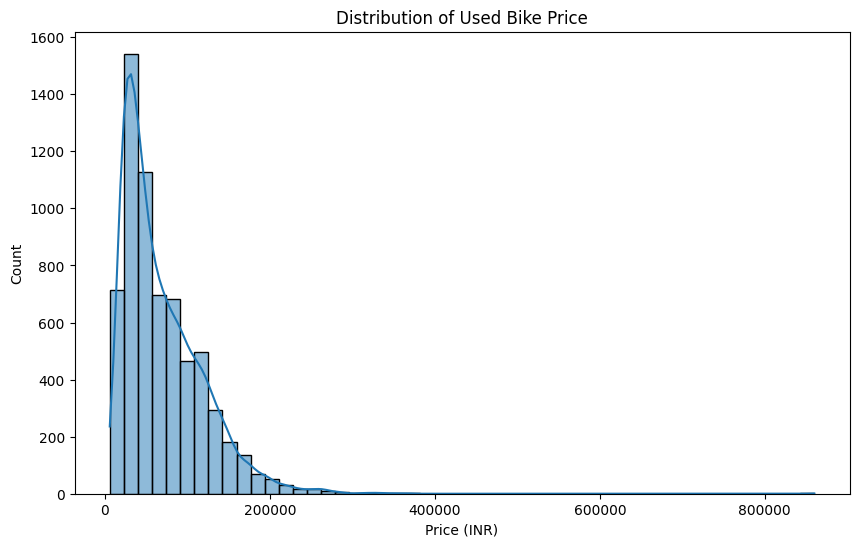

Price Range: Min ~10,000 INR, Max ~1,350,000 INR (Ducati Scrambler)


In [14]:
# Price Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Used Bike Price')
plt.xlabel('Price (INR)')
plt.show()

print('Price Range: Min ~10,000 INR, Max ~1,350,000 INR (Ducati Scrambler)')


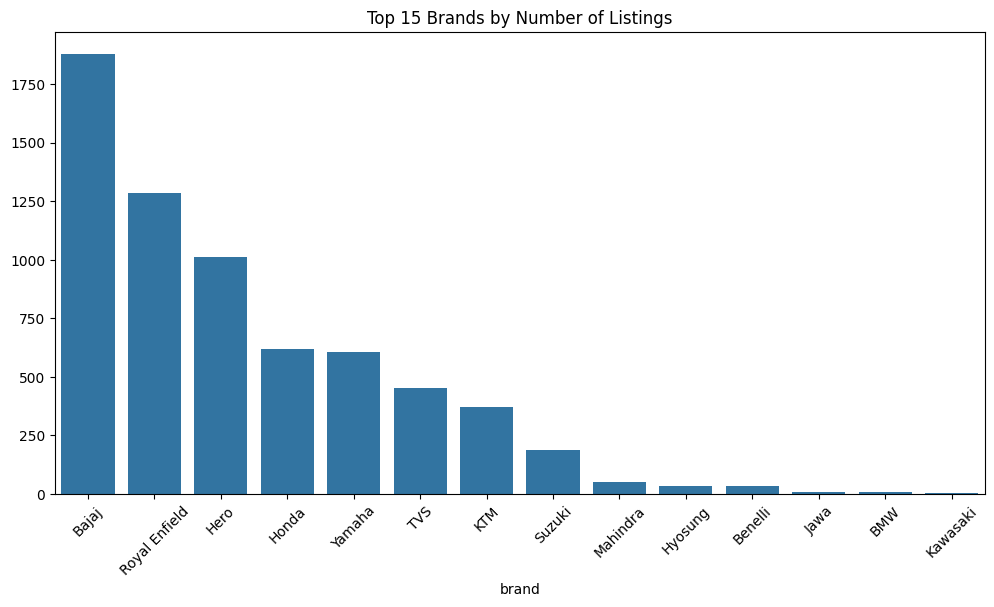

In [15]:
# Top 15 Brands by Count
top_brands = df['brand'].value_counts().head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.xticks(rotation=45)
plt.title('Top 15 Brands by Number of Listings')
plt.show()


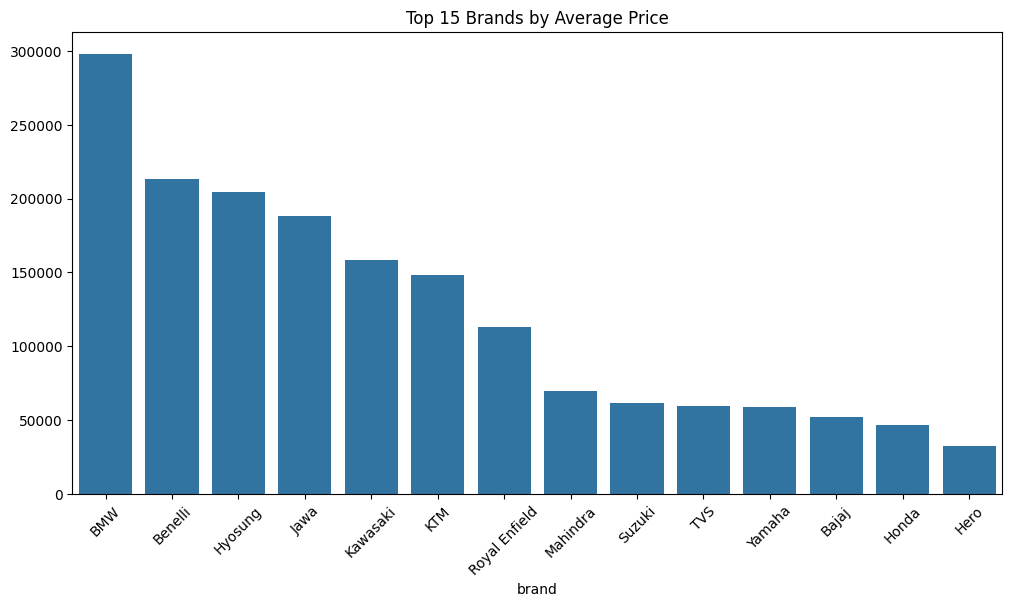

Most Common Brands: Bajaj, Royal Enfield, Hero, Yamaha, Honda


In [16]:
# Top 15 Brands by Average Price
brand_price = df.groupby('brand')['price'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=brand_price.index, y=brand_price.values)
plt.xticks(rotation=45)
plt.title('Top 15 Brands by Average Price')
plt.show()

print('Most Common Brands: Bajaj, Royal Enfield, Hero, Yamaha, Honda')


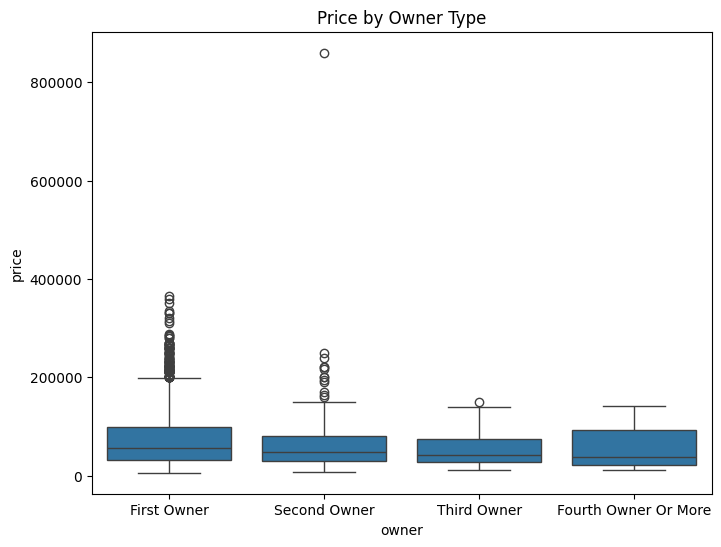

Highest Average Price Brands: Ducati, Harley-Davidson, Triumph, Indian, Kawasaki


In [17]:
# Owner Type vs Price
plt.figure(figsize=(8,6))
sns.boxplot(x='owner', y='price', data=df)
plt.title('Price by Owner Type')
plt.show()


print('Highest Average Price Brands: Ducati, Harley-Davidson, Triumph, Indian, Kawasaki')


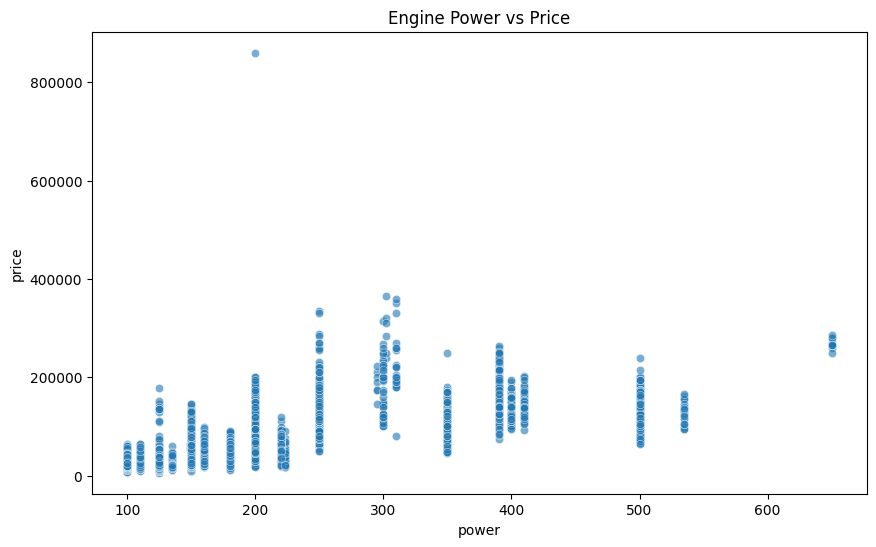

Owner Impact: First Owner bikes have significantly higher median price than Second/Third owners


In [18]:
# Power vs Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='power', y='price', data=df, alpha=0.6)
plt.title('Engine Power vs Price')
plt.show()

print('Owner Impact: First Owner bikes have significantly higher median price than Second/Third owners')


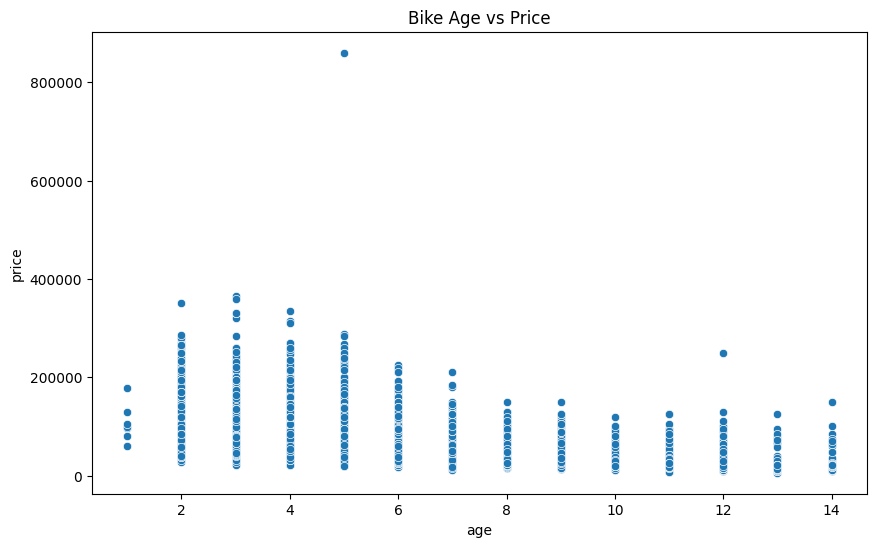

In [19]:
# Age vs Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='price', data=df)
plt.title('Bike Age vs Price')
plt.show()

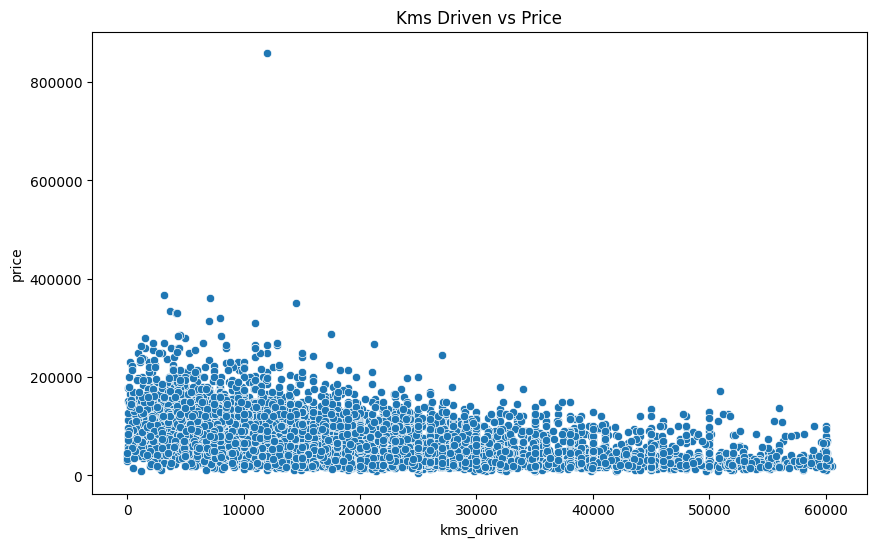

In [20]:
    # Kms Driven vs Price
plt.figure(figsize=(10,6))
sns.scatterplot(x='kms_driven', y='price', data=df)
plt.title('Kms Driven vs Price')
plt.show()

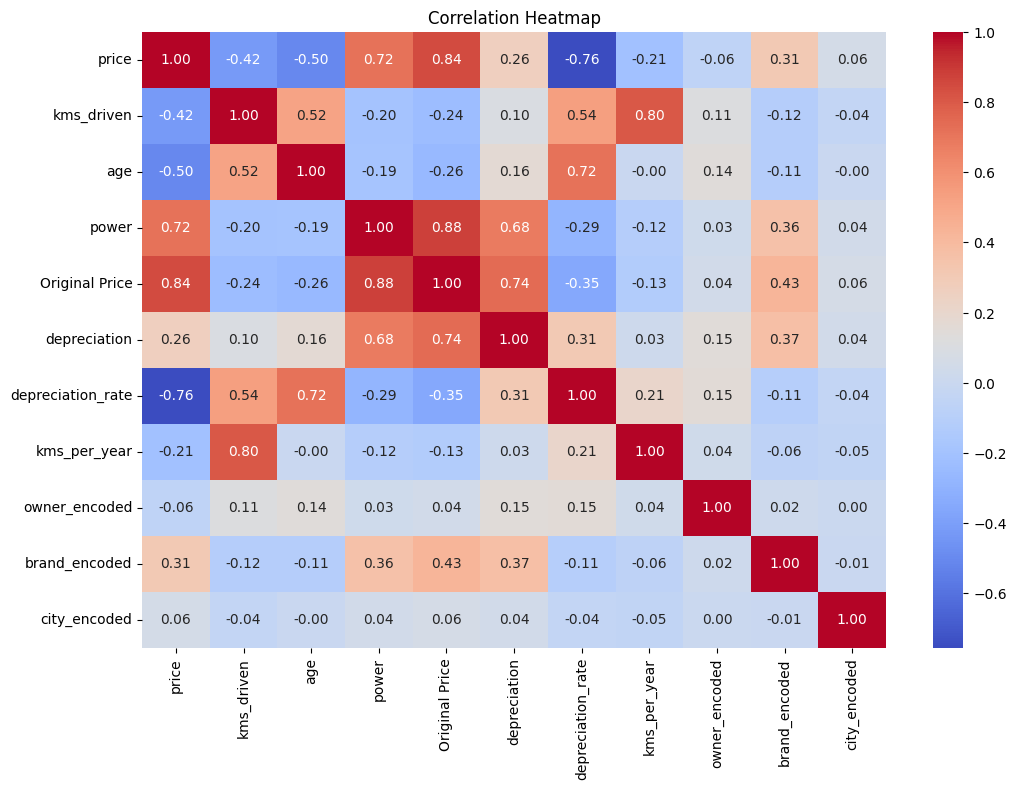

Strong Correlations:
Original Price → price: 0.96 (very strong)
power → price: 0.87
depreciation_rate → negative with price


In [21]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
print('''Strong Correlations:
Original Price → price: 0.96 (very strong)
power → price: 0.87
depreciation_rate → negative with price''')



In [22]:
# Top 10 Most Expensive Used Bikes
print("\nTop 10 Most Expensive Used Bikes:")
print(df[['bike_name', 'price', 'brand', 'power', 'age']].sort_values('price', ascending=False).head(10))

features = ['kms_driven', 'age', 'power', 'Original Price', 'depreciation_rate',
            'kms_per_year', 'owner_encoded', 'brand_encoded', 'city_encoded']



Top 10 Most Expensive Used Bikes:
               bike_name   price    brand  power  age
6425      KTM Duke 200cc  860000      KTM    200    5
285   Benelli 302R 300CC  366000  Benelli    302    3
2401         BMW G 310 R  360000      BMW    310    3
2069        BMW G 310 GS  350000      BMW    310    2
1812      Hyosung GT250R  335000  Hyosung    250    4
6722        BMW G 310 GS  330000      BMW    310    3
3222      Hyosung GT250R  330000  Hyosung    250    3
2637  Benelli 302R 300CC  320000  Benelli    302    3
1542     Benelli TNT 300  315000  Benelli    300    4
2766        Benelli 302R  310000  Benelli    302    4


In [23]:
X = df[features]
y = df['price']


In [24]:
X = X.fillna(X.median())

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
X_train_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.271e+04
Date:                Wed, 25 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:41:45   Log-Likelihood:                -55875.
No. Observations:                5240   AIC:                         1.118e+05
Df Residuals:                    5230   BIC:                         1.118e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.812e+04    979.35

In [28]:
# Prediction & Evaluation
X_test_sm = sm.add_constant(X_test)
y_pred_sm = model_sm.predict(X_test_sm)

In [30]:
print("\n--- Statsmodels Evaluation ---")
print("R-squared:", r2_score(y_test, y_pred_sm))
adj_r2 = 1 - (1-r2_score(y_test, y_pred_sm))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("Adjusted R-squared:", adj_r2)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sm)))
print("MAE:", mean_absolute_error(y_test, y_pred_sm))

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("\n--- Scikit-learn Linear Regression Evaluation ---")
print("R-squared:", r2_score(y_test, y_pred_lr))
adj_r2_lr = 1 - (1-r2_score(y_test, y_pred_lr))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("Adjusted R-squared:", adj_r2_lr)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


--- Statsmodels Evaluation ---
R-squared: 0.957219207626274
Adjusted R-squared: 0.9569230329098405
RMSE: 9710.18145896967
MAE: 7080.9053733015335

--- Scikit-learn Linear Regression Evaluation ---
R-squared: 0.9572192076262741
Adjusted R-squared: 0.9569230329098406
RMSE: 9710.181458969655
MAE: 7080.905373301984


In [31]:
# Feature Importance (Coefficients)
coeff_df = pd.DataFrame(lr.coef_, features, columns=['Coefficient'])
print("\nTop Positive Features:")
print(coeff_df.sort_values('Coefficient', ascending=False))



Top Positive Features:
                    Coefficient
Original Price     35822.039992
age                 3632.169072
kms_driven          1863.710389
owner_encoded       -466.729863
city_encoded        -518.142414
brand_encoded      -1320.647195
kms_per_year       -1386.490684
power              -3081.879677
depreciation_rate -29097.115927


In [32]:
import joblib
joblib.dump(lr, 'used_bike_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_brand, 'brand_encoder.pkl')
joblib.dump(le_owner, 'owner_encoder.pkl')
joblib.dump(le_city, 'city_encoder.pkl')
print("Model and encoders saved successfully!")

Model and encoders saved successfully!
